In [1]:
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def process_bigdl_log(logfname,epoch_size):
    result = {}
    import re  
    trainiter = re.compile('.*(\d\d\d\d\-\d+-\d+\s+\d+\:\d+\:\d+)\s+INFO\s+DistriOptimizer\$\:\d+\s+\-\s+\[Epoch\s+(\d+)\s+(\d+)\/\d+\]\[Iteration\s+(\d+)\]\[Wall\s+Clock\s+(\d+\.\d+)s\]\s+Train\s+(\d+)\s+in\s+(\d+.\d+)\s*seconds\.\s+Throughput\s+is\s+(\d+\.\d+)\s+records\/second\.\s+Loss\s+is\s+(\d+.\d+)\.')
    epochfinish = re.compile('.*(\d\d\d\d\-\d+-\d+\s+\d+\:\d+\:\d+)\s+INFO\s+DistriOptimizer\$\:\d+\s+\-\s+\[Epoch\s+(\d+)\s+(\d+)\/\d+\]\[Iteration\s+(\d+)\]\[Wall\s+Clock\s+(\d+\.\d+)s\]\s+Epoch\s+finished\.\s+Wall\s+clock\s+time\s+is\s+([-+]?(\d+([.,]\d*)?|[.,]\d+)([eE][-+]?\d+)?)ms')
    top1acc = re.compile('.*(\d\d\d\d\-\d+-\d+\s+\d+\:\d+\:\d+)\s+INFO\s+DistriOptimizer\$\:\d+\s+\-\s+top1\s+accuracy\s+is\s+Accuracy\(correct\:\s+\d+,\s+count\:\s+\d+,\s+accuracy\:\s+(\d+\.\d+)\)')
    top5acc = re.compile('.*(\d\d\d\d\-\d+-\d+\s+\d+\:\d+\:\d+)\s+INFO\s+DistriOptimizer\$\:\d+\s+\-\s+top5\s+accuracy\s+is\s+Accuracy\(correct\:\s+\d+,\s+count\:\s+\d+,\s+accuracy\:\s+(\d+\.\d+)\)')

    with open(logfname) as logf:
        contents = logf.readlines()
        print len(contents)," of log lines to process"
        cur_iter = 0
        cur_epoch = 0
        for log in contents:
            trainiterm = trainiter.match(log)
            epochfinishm = epochfinish.match(log)
            testtop1accm = top1acc.match(log)
            testtop5accm = top5acc.match(log)
            if trainiterm:
                cur_epoch,processed_size,cur_iter,wall,bs,traintime,tput,loss = [eval(n) for n in trainiterm.groups()[1:]]
                result[cur_iter] = {'epoch':cur_epoch,'loss':loss,'lr':0,'top1':0}
            elif epochfinishm:
                cur_epoch = eval(epochfinishm.group(2))
                cur_iter = eval(epochfinishm.group(4))
                result[cur_iter] = result.get(cur_iter,{})
                result[cur_iter]['epoch'] = cur_epoch
                result[cur_iter]['end_of_epoch'] = True
                #print log
            elif testtop1accm:
                top1=eval(testtop1accm.group(2))
                result[cur_iter]['testtop1'] = top1
            elif testtop5accm:
                top5=eval(testtop5accm.group(2))
                result[cur_iter]['testtop5'] = top5
            else:
                pass
        #prepare ndarrays for plotting
        train_tbl = np.zeros((4,len(result.keys()))) #iter,trainloss3
        test_tbl = np.zeros((5,len(result.keys()))) #iter,lr,trainloss3,testtop1,testtop5
        test_tbl_epoch = np.zeros((5,999))
        #print result
        #get all test results with train lr
        idx_train = 0
        idx_test = 0
        idx_test_epoch = 0
        for iter,values in sorted(result.items()):
            #print iter,values
            train_tbl[0][idx_train] = iter # iteration
            train_tbl[1][idx_train] = values['epoch'] #epoch
            train_tbl[2][idx_train] = values['lr']
            train_tbl[3][idx_train] = values['loss']
            idx_train = idx_train + 1
            if values.has_key('testtop1') or values.has_key('testtop5'):
                #print iter,values
                test_tbl[0][idx_test] = iter # iteration
                test_tbl[1][idx_test] = values.get('lr',0)
                test_tbl[2][idx_test] = values.get('loss',0)
                test_tbl[3][idx_test] = values.get('testtop1',0)
                test_tbl[4][idx_test] = values.get('testtop5',0)
                idx_test = idx_test + 1
                if values.has_key('end_of_epoch'):
                    test_tbl_epoch[0][idx_test_epoch] = values.get('epoch') #epoch
                    test_tbl_epoch[1][idx_test_epoch] = values.get('lr',0)
                    test_tbl_epoch[2][idx_test_epoch] = values.get('loss',0)
                    test_tbl_epoch[3][idx_test_epoch] = values.get('testtop1',0)
                    test_tbl_epoch[4][idx_test_epoch] = values.get('testtop5',0)
                    idx_test_epoch = idx_test_epoch + 1          
        print train_tbl[:,0:idx_train].shape[1],' train record found'
        print test_tbl[:,0:idx_test].shape[1],' test record found'
        print test_tbl_epoch[:,0:idx_test].shape[1],'test epoch record found'
        return train_tbl[:,:idx_train],test_tbl[:,:idx_test],test_tbl_epoch[:,:idx_test]
 
                

In [4]:
def process_torch_log(logfname,epoch_size):
    train = {}
    test = {}
    
    import re
    trainp = re.compile('Epoch:\s+\[(\d+)\]\[(\d+)\/(\d+)\]\s+Time\s+(\d+\.\d+)\s+Err\s+(\d+\.\d+)\s+Top1\-\%\:\s+(\d+\.\d+)\s+LR\s+([\d|e|\.\-]+)\s+DataLoadingTime\s+(\d+\.\d+)*')
    testp = re.compile('Epoch:\s+\[(\d+)\]\[TESTING\s+SUMMARY\]\s+Total\s+Time\(s\):\s+(\d+\.\d+)\s+average\s+loss\s+\(per\s+batch\):\s+(\d+\.\d+)\s+accuracy\s+\[Center\]\(\%\):\s+top\-1\s+(\d+\.\d+)')
    #added top5 accuracy
    testpnew = re.compile('Epoch:\s+\[NEW\]\s*\[(\d+)\]\[TESTING\s+SUMMARY\]\s+Total\s+Time\(s\):\s+(\d+\.\d+)\s+average\s+loss\s+\(per\s+batch\):\s+(\d+\.\d+)\s+accuracy\s+\[Center\]\(\%\):\s+top\-1\s+(\d+\.\d+)\s+top\-5\s+(\d+\.\d+)')
    
    with open(logfname) as log:
        contents = log.readlines()
        print len(contents)," of log lines to process"
        iteration_logs = [ trainp.match(l) for l in contents if trainp.match(l)]
        test_logs = [testp.match(l) for l in contents if testp.match(l)]
        testnew_logs = [testpnew.match(l) for l in contents if testpnew.match(l)]
        print len(iteration_logs)," lines of iteration logs to process"
        print len(test_logs)," lines of of test logs to process"
        print len(testnew_logs)," lines of of [NEW] test logs to process"
        it = 0
        epoch = 0
        print "Start Processing Logs... "
        epochSize = 0
        for log in iteration_logs:
            #print log.groups()
            epoch,it,total_iters,time,err,top1,lr,loadt= [eval(n) for n in log.groups()]
            train[epoch] = train.get(epoch, {})
            epochSize = total_iters # should be same for all epochs
            if epochSize != epoch_size:
                print "Warning: epoch size settings is not equal to the epoch size detected!"
            train[epoch][it] = {'loss':err,'lr':lr,'top1':top1}
            #train[epoch][1][it] = err
            #train[epoch][2][it] = lr
            #train[epoch][3][it] = top1
        if len(testnew_logs) != 0 :
            for log in testnew_logs:
                epoch,total_time,avg_loss,top1,top5 = [eval(n) for n in log.groups()]
                test[epoch] = test.get(epoch, {})
                test[epoch]['loss'] = avg_loss
                test[epoch]['top1'] = top1
                test[epoch]['top5'] = top5
        else:
            if len(test_logs) == 0:
                print "no test logs found!"
            for log in test_logs:
                epoch,total_time,avg_loss,top1 = [eval(n) for n in log.groups()]
                test[epoch] = test.get(epoch, {})
                test[epoch]['loss'] = avg_loss
                test[epoch]['top1'] = top1
                test[epoch]['top5'] = 0
        print "Done Log Processing."
        #prepare ndarrays for plotting, conform with caffe analyse result format
        train_tbl = np.zeros((4,len(train.keys()*epochSize))) #iter,trainloss3
        test_tbl = np.zeros((5,len(test.keys()))) #iter,lr,trainloss3,testtop1,testtop5
        test_tbl_epoch = np.zeros((5,len(test.keys())))
        #turn test into nd arrays and sync with caffe result tables
        idx_train = 0
        for epoch,epochData in sorted(train.items()):
            for iter,iterData in sorted(epochData.items()):
                train_tbl[0][idx_train] = (epoch-1)*epochSize + iter # iteration
                train_tbl[1][idx_train] = epoch + float(iter)/epochSize # epoch
                train_tbl[2][idx_train] = iterData['lr'] #lr
                train_tbl[3][idx_train] = iterData['loss'] #loss
                idx_train = idx_train + 1
        idx_test = 0
        for epoch,epochData in sorted(test.items()):
            test_tbl[0][idx_test] = epoch*epochSize
            test_tbl[1][idx_test] = train[epoch][epochSize]['lr']
            test_tbl[2][idx_test] = train[epoch][epochSize]['loss'] # total loss
            test_tbl[3][idx_test] = epochData['top1']/100.0
            test_tbl[4][idx_test] = epochData['top5']/100.0 #top5
            test_tbl_epoch[0][idx_test] = epoch
            test_tbl_epoch[1][idx_test] = train[epoch][epochSize]['lr']
            test_tbl_epoch[2][idx_test] = train[epoch][epochSize]['loss'] # total loss
            test_tbl_epoch[3][idx_test] = epochData['top1']/100.0
            test_tbl_epoch[4][idx_test] = epochData['top5']/100.0 #top5
            idx_test = idx_test + 1
            #test_tbl[4][idx_test] = epochData['top5']
        #return the train, test results and the last epoch and last iteration
        print train_tbl[:,0:idx_train].shape[1],' train record found'
        print test_tbl[:,0:idx_test].shape[1],' test record found'
        print test_tbl_epoch[:,0:idx_test].shape[1],'test epoch record found'
        return train_tbl[:,:idx_train],test_tbl[:,:idx_test],test_tbl_epoch[:,:idx_test]

In [5]:
def process_caffe_log(logfname,epoch_size):
    print "processing caffe logs"
    result = {}
    
    import re
    trainiter = re.compile('I(\d\d\d\d\s+\d\d\:\d\d\:\d\d\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Iteration\s+(\d+),\s+loss\s+=\s+([-+]?(\d+([.,]\d*)?|[.,]\d+)([eE][-+]?\d+)?)')
    trainnetloss3 = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Train\s+net\s+output\s+#\d\:\s+loss3\/loss\s+=\s+(\d+.\d+)*')
    trainiterlr = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+sgd_solver\.cpp\:\d+\]\s+Iteration\s+(\d+),\s+lr\s+=\s+([-+]?(\d+([.,]\d*)?|[.,]\d+)([eE][-+]?\d+)?)')
    testiter = re.compile('I(\d+\s+\d+\:\d+\:\d+.\d+\s+\d+)\s+solver\.cpp\:\d+\]\s+Iteration\s+(\d+),\s+Testing\s+net\s+\(#\d+\)')
    testnettop1 = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Test\s+net\s+output\s+#\d+\:\s+loss3\/top-1\s+=\s+(\d+\.\d+)\s*')
    testnettop5 = re.compile('I(\d+\s+\d+\:\d+\:\d+\.\d+)\s+\d+\s+solver\.cpp\:\d+\]\s+Test\s+net\s+output\s+#\d+\:\s+loss3\/top-5\s+=\s+(\d+\.\d+)\s*')
    with open(logfname) as log:
        contents = log.readlines()
        print len(contents)," of log lines to process"
        print "Start Processing Logs..."
        cur_iter = 0
        for log in contents:
            trainiterm = trainiter.match(log)
            trainnetloss3m = trainnetloss3.match(log)
            trainiterlrm = trainiterlr.match(log)
            testiterm = testiter.match(log)
            testnettop1m = testnettop1.match(log)
            testnettop5m = testnettop5.match(log)
            if trainiterm or testiterm:
                cur_iter = eval(trainiterm.group(2) if trainiterm else testiterm.group(2))
                result[cur_iter] = result.get(cur_iter,{})
                if trainiterm :
                    result[cur_iter]['loss'] = eval(trainiterm.group(3))
                #print "current iteration = ",cur_iter
            elif trainiterlrm :
                result[eval(trainiterlrm.group(2))]['lr'] = eval(trainiterlrm.group(3))
            elif trainnetloss3m:
                result[cur_iter]['trainloss3'] = eval(trainnetloss3m.group(2))
            elif testnettop1m :
                result[cur_iter]['testtop1'] = eval(testnettop1m.group(2))
            elif testnettop5m :
                result[cur_iter]['testtop5'] = eval(testnettop5m.group(2))
            else :
                #print "log doesn't match any of the patterns: ",log
                pass
        print "Done Log Processing."
        
        #prepare ndarrays for plotting
        train_tbl = np.zeros((4,len(result.keys()))) #iter,trainloss3
        test_tbl = np.zeros((5,len(result.keys()))) #iter,lr,trainloss3,testtop1,testtop5
        test_tbl_epoch = np.zeros((5,999))
        #print result
        #get all test results with train lr
        idx_train = 0
        idx_test = 0
        idx_test_epoch = 0
        for iter,values in sorted(result.items()):
            #print iter,values
            if values.has_key('trainloss3'):
                train_tbl[0][idx_train] = iter # iteration
                train_tbl[1][idx_train] = float(iter)/epoch_size + 1 #epoch
                train_tbl[2][idx_train] = values['lr']
                train_tbl[3][idx_train] = values['loss']
                idx_train = idx_train + 1
            if values.has_key('testtop1'):
                #print iter,values
                test_tbl[0][idx_test] = iter # iteration
                test_tbl[1][idx_test] = values.get('lr',0)
                test_tbl[2][idx_test] = values.get('loss',0)
                test_tbl[3][idx_test] = values['testtop1']
                test_tbl[4][idx_test] = values['testtop5']
                idx_test = idx_test + 1
                if iter%epoch_size == 0:
                    test_tbl_epoch[0][idx_test_epoch] = int(iter/epoch_size) #epoch
                    test_tbl_epoch[1][idx_test_epoch] = values.get('lr',0)
                    test_tbl_epoch[2][idx_test_epoch] = values.get('loss',0)
                    test_tbl_epoch[3][idx_test_epoch] = values['testtop1']
                    test_tbl_epoch[4][idx_test_epoch] = values['testtop5']
                    idx_test_epoch = idx_test_epoch + 1
        print train_tbl[:,0:idx_train].shape[1],' train record found'
        print test_tbl[:,0:idx_test].shape[1],' test record found'
        print test_tbl_epoch[:,0:idx_test_epoch].shape[1],'test epoch record found'
        #return the errs, top1 accuracy and the last epoch and last iteration
        return train_tbl[:,0:idx_train],test_tbl[:,0:idx_test],test_tbl_epoch[:,0:idx_test_epoch]

In [6]:
def process_log(fmat,log,epoch_size):
    if fmat=='caffe': 
        return process_caffe_log(log,epoch_size)
    elif fmat == 'torch':
        return process_torch_log(log,epoch_size)
    elif fmat == 'bigdl':
        return process_bigdl_log(log,epoch_size)
    else:
        print "unknown log format",fmat
        return None

In [119]:
tests = [
    #('caffe','caffe-32-step','/home/user/shane/caffe/yiheng-googlenetv2-bs32-1GPU.log',128*10000/32),
    #('caffe','caffe-256-step','/home/user/shane/caffe/yiheng-googlenetv2-bs32x8-8GPU.log',128*10000/256),
    #('caffe','caffe-512-step','/home/user/shane/caffe/gv2-bs64x8-8GPU-step.log',128*10000/512),
    #('caffe','caffe-512-triangular2','/home/user/shane/caffe/gv2-bs64x8-8GPU-tri2.log',128*10000/512),
    #('caffe','caffe-512-step-scaled-stepsize','/home/user/shane/caffe/gv2-bs64x8-8GPU-step-stepsize-scaled.log',128*10000/512),
    #('caffe','caffe-512-hybrid(step+tri2)','/home/user/shane/caffe/gv2-bs64x8-8GPU-tri2-boost-step-from50000.log',128*10000/512),
    #('caffe','caffe-512-step-rescaled-linear-b0.72','/home/user/shane/caffe/gv2-bs64x8-8GPU-step-rescaledlrvalue-16x.log',128*10000/512),
    #('caffe','caffe-512-step-rescaled-3/4linear-b0.54','/home/user/shane/caffe/gv2-bs64x8-8GPU-step-rescaledlrvalue-12x.log',128*10000/512),
    ('caffe','caffe-512-step-rescaled-1/2linear-b0.36','/home/user/shane/caffe/gv2-bs64x8-8GPU-step-rescaledlrvalue-8x.log',128*10000/512),
    #('caffe','caffe-512-step-rescaled-1/4linear-b0.18','/home/user/shane/caffe/gv2-bs64x8-8GPU-step-rescaledlrvalue-4x.log',128*10000/512),
    #('caffe','caffe-512-exprange-b0.04-m0.1-g0.99998','/home/user/shane/caffe/gv2-bs64x8-8GPU-exprange.log',128*10000/512),
    #('caffe','caffe-512-exprange-b0.0003-m0.2-g0.99998','/home/user/shane/caffe/gv2-bs64x8-8GPU-exprange-2.log',128*10000/512),
    #('torch','torch-128-original','/home/user/shane/soumith-imgnet-training/torch-yiheng-googlenetv2-bs128-8GPU.log',128*10000/128),
    #('torch','torch-256-original','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs256-8GPU.log',128*10000/256),
    #('torch','torch-896-original','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU.log',1430),
    #('torch','torch-896-triangular2','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU-triangular2-t1.log',1430),
    #('torch','torch-896-triangular2-hybrid','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU-triangular2-t2.log',1430),
    #('torch','torch-896-step-b0.36','/home/user/shane/soumith-imgnet-training/torch-gv2-bs896-8GPU-step-0.36.log',1430),
    #('torch','torch-896-step-b0.6','/home/user/shane/soumith-imgnet-training/torch-gv2-bs896-8GPU-step-0.6.log',1430),  
    #('torch','torch-896-exprange-b0.0003-m0.2-g0.99998','/home/user/shane/soumith-imgnet-training/torch-gv2-bs896-8GPU-exprange-1.log',1430),
    #('torch','torch-896-exprange-b0.0003-m0.2-g0.99998-1epochstep','/home/user/shane/soumith-imgnet-training/torch-gv2-bs896-8GPU-exprange-2.log',1430),
    #('torch','torch-896-exprange-b0.0003-m0.2-g0.9-3epochstep','/home/user/shane/soumith-imgnet-training/torch-gv2-bs896-8GPU-exprange-3.log',1430),
    #('bigdl','bigdl-896-step-b0.36-s900-part1','/home/user/shane/BigDL/bigdl-bs896-step-0.36-part1.log',1430),
    #('bigdl','bigdl-896-step-b0.36-s900-part2','/home/user/shane/BigDL/bigdl-bs896-step-0.36-newcode.log',1430),
    #('bigdl','bigdl-896-step-b0.24-s900-part1','/home/user/shane/BigDL/bigdl-bs896-step-0.24.log',1430),
    #('bigdl','bigdl-896-step-b0.24-s400-part2','/home/user/shane/BigDL/bigdl-bs896-step-0.24-part2.log',1430),
    #('bigdl','bigdl-896-step-b0.24-s400-part3','/home/user/shane/BigDL/bigdl-bs896-step-0.24-part5.log',1430),
    ('bigdl','bigdl-512-step-b0.36-s400-part1','/home/user/shane/BigDL/bigdl-bs512-step-0.36.log',128*10000/512),
    ('bigdl','bigdl-512-step-b0.36-s400-part2','/home/user/shane/BigDL/bigdl-bs512-step-0.36-part2.log',128*10000/512),
]
result_tbls = []
for (fmat,label,log,epoch_size) in tests:
    print 'TEST ===',label,'==='
    print log
    train1,test1,test1_epoch = process_log(fmat,log,epoch_size)
    result_tbls.append({'label':label,'train_result':train1,'test_result':test1,'test_result_epoch':test1_epoch})

TEST === caffe-512-step-rescaled-1/2linear-b0.36 ===
/home/user/shane/caffe/gv2-bs64x8-8GPU-step-rescaledlrvalue-8x.log
processing caffe logs
18969  of log lines to process
Start Processing Logs...
Done Log Processing.
1875  train record found
30  test record found
30 test epoch record found
TEST === bigdl-512-step-b0.36-s400-part1 ===
/home/user/shane/BigDL/bigdl-bs512-step-0.36.log
40205  of log lines to process
40048  train record found
15  test record found
15 test epoch record found
TEST === bigdl-512-step-b0.36-s400-part2 ===
/home/user/shane/BigDL/bigdl-bs512-step-0.36-part2.log
57903  of log lines to process
57731  train record found
23  test record found
23 test epoch record found


In [56]:
#### formattings
def plot_formats(num):
    #from itertools import cycle
    #lines = ["-","--"]
    #linecycler = cycle(lines)   
    color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
    if num > len(color_sequence):
        print "not enough color sequence, add more colors"
        return
    lwidths = np.linspace(1,4,num)
    formats = [{'lw':lw,'color':color} for lw,color in zip(lwidths,color_sequence[0:num])]
    return formats

In [57]:
def plot_lr_iter(position,result_tbls,lineformats=None):
    ymax = 0
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': learning rate vs. iteration')
    if lineformats == None:
        for result in result_tbls:
            ymax = max(ymax,max(result['train_result'][2,:]))
            plt.plot(result['train_result'][0,:],result['train_result'][2,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            ymax = max(ymax,max(result['train_result'][2,:]))
            plt.plot(result['train_result'][0,:],result['train_result'][2,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='upper right',fontsize=8)
    plt.grid(True)
    plt.xlabel('iteration')
    plt.ylabel('learning rate')
    plt.ylim((0,ymax*1.05))

In [58]:
def plot_lr_epoch(position,result_tbls,lineformats=None):
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': learning rate vs. epoch')
    ymax = 0
    if lineformats == None:
        for result in result_tbls:
            ymax = max(ymax,max(result['train_result'][2,:]))
            plt.plot(result['train_result'][1,:],result['train_result'][2,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            ymax = max(ymax,max(result['train_result'][2,:]))
            plt.plot(result['train_result'][1,:],result['train_result'][2,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='upper right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('learning rate')
    plt.ylim((0,ymax*1.05))

In [59]:
def plot_loss_iter(position,result_tbls,lineformats=None):
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': train loss vs. iteration')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['train_result'][0,:],result['train_result'][3,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['train_result'][0,:],result['train_result'][3,:],label=result['label'],color=lineformats['color'])
    ax.legend(loc='upper right',fontsize=8)
    plt.grid(True)
    plt.xlabel('iteration')
    plt.ylabel('train loss')

In [60]:
def plot_loss_epoch(position,result_tbls,lineformats=None):
    ax=plt.subplot(position)
    plt.title('fig '+str(position%10)+': train loss vs. epoch')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['train_result'][1,:],result['train_result'][3,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['train_result'][1,:],result['train_result'][3,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='upper right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('train loss')

In [61]:
def plot_top1_iter(position,result_tbls,lineformats=None):
    ax=plt.subplot(position)
    major_ticks = np.arange(0, 1.01, 0.1)                                              
    minor_ticks = np.arange(0, 1.01, 0.05)
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)                                                
    plt.title('fig '+str(position%10)+': top1 accr vs. iteration')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['test_result'][0,:],result['test_result'][3,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['test_result'][0,:],result['test_result'][3,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.xlabel('iteration')
    plt.ylabel('top1 accr')
    plt.ylim((0,1))
    plt.xlim(xmin=0)

In [62]:
def plot_top5_iter(position,result_tbls,lineformats=None):
    #plot the error
    ax=plt.subplot(position)
    major_ticks = np.arange(0, 1.01, 0.1)                                              
    minor_ticks = np.arange(0, 1.01, 0.05)
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)                                                
    plt.title('fig '+str(position%10)+': top5 accr vs. iteration')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['test_result'][0,:],result['test_result'][4,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['test_result'][0,:],result['test_result'][4,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.ylim((0,1))
    plt.xlim(xmin=0)
    #=========== annotation begin ===========
    #the spot on 256-step
    #spot=(result_tbls[1]['test_result'][0,20],result_tbls[1]['test_result'][4,20])
    #plt.scatter([spot[0], ], [spot[1], ], 50, color='grey')
    #plt.annotate(r'iteration 200000',
    #             xy=(spot[0], spot[1]), xycoords='data',
    #             xytext=(+10, -50), textcoords='offset points', fontsize=10,
    #             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    #the spot on 512-triangular2
    #spot=(result_tbls[3]['test_result'][0,98],result_tbls[3]['test_result'][4,98])
    #plt.scatter([spot[0], ], [spot[1], ], 50, color='grey')
    #plt.annotate(r'iteration 100000',
    #             xy=(spot[0], spot[1]), xycoords='data',
    #             xytext=(+10, +20), textcoords='offset points', fontsize=10,
    #             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
    #=========== annotation end ===========
    plt.xlim(xmin=0)
    plt.xlabel('iteration')
    plt.ylabel('top5 accr')

In [63]:
def plot_top1_epoch(position,result_tbls,lineformats=None):
    ax=plt.subplot(position)
    major_ticks = np.arange(0, 1.01, 0.1)                                              
    minor_ticks = np.arange(0, 1.01, 0.05)
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)                                                
    plt.title('fig '+str(position%10)+': top1 accr vs. epoch')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][3,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][3,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('top1 accr')
    plt.ylim((0,1))
    plt.xlim(xmin=0)

In [64]:
def plot_top5_epoch(position,result_tbls,lineformats=None):
    #plot the error
    ax=plt.subplot(position)
    major_ticks = np.arange(0, 1.01, 0.1)                                              
    minor_ticks = np.arange(0, 1.01, 0.05)
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)                                                
    plt.title('fig '+str(position%10)+': top5 accr vs. epoch')
    if lineformats == None:
        for result in result_tbls:
            plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][4,:],label=result['label'])
    else:
        for result,lineformat in zip(result_tbls,lineformats):
            plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][4,:],label=result['label'],color=lineformat['color'])
    ax.legend(loc='lower right',fontsize=8)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('top5 accr')
    plt.ylim((0,1))
    plt.xlim(xmin=0)


In [65]:
def find_final_accuracy(testspecs,result_tbls):
    for test,result in zip(testspecs,result_tbls):
        print 'TEST MAX ACCURACY:',result['label']
        #am = result['test_result'].max(axis=1)
        if result['test_result'].shape[1] == 0:
            print "No test result available yet"
            continue
        maxind = result['test_result'].argmax(axis=1)
        print 'maxiter_top1 = ',result['test_result'][0,maxind[3]],'max_epoch_top1=',int(result['test_result'][0,maxind[3]]/test[3]),'top1acc =',result['test_result'][3,maxind[3]],'top5acc =',result['test_result'][4,maxind[3]]
        print 'maxiter_top5 = ',result['test_result'][0,maxind[4]],'max_epoch_top1=',int(result['test_result'][0,maxind[4]]/test[3]),'top1acc =',result['test_result'][3,maxind[4]],'top5acc =',result['test_result'][4,maxind[4]]
        maxind = result['train_result'].argmax(axis=1)
        minind = result['train_result'].argmin(axis=1)
        print 'max lr = ',result['train_result'][2,maxind[2]],'min lr = ',result['train_result'][2,minind[2]]
        

TEST MAX ACCURACY: caffe-512-step-rescaled-1/2linear-b0.36
maxiter_top1 =  67500.0 max_epoch_top1= 27 top1acc = 0.711187 top5acc = 0.9025
maxiter_top5 =  67500.0 max_epoch_top1= 27 top1acc = 0.711187 top5acc = 0.9025
max lr =  0.36 min lr =  0.000174189
TEST MAX ACCURACY: bigdl-512-step-b0.36-s400-part1
maxiter_top1 =  37545.0 max_epoch_top1= 15 top1acc = 0.57934 top5acc = 0.80956
maxiter_top5 =  37545.0 max_epoch_top1= 15 top1acc = 0.57934 top5acc = 0.80956
max lr =  0.0 min lr =  0.0
TEST MAX ACCURACY: bigdl-512-step-b0.36-s400-part2
maxiter_top1 =  85101.0 max_epoch_top1= 34 top1acc = 0.63758 top5acc = 0.84804
maxiter_top5 =  85101.0 max_epoch_top1= 34 top1acc = 0.63758 top5acc = 0.84804
max lr =  0.0 min lr =  0.0


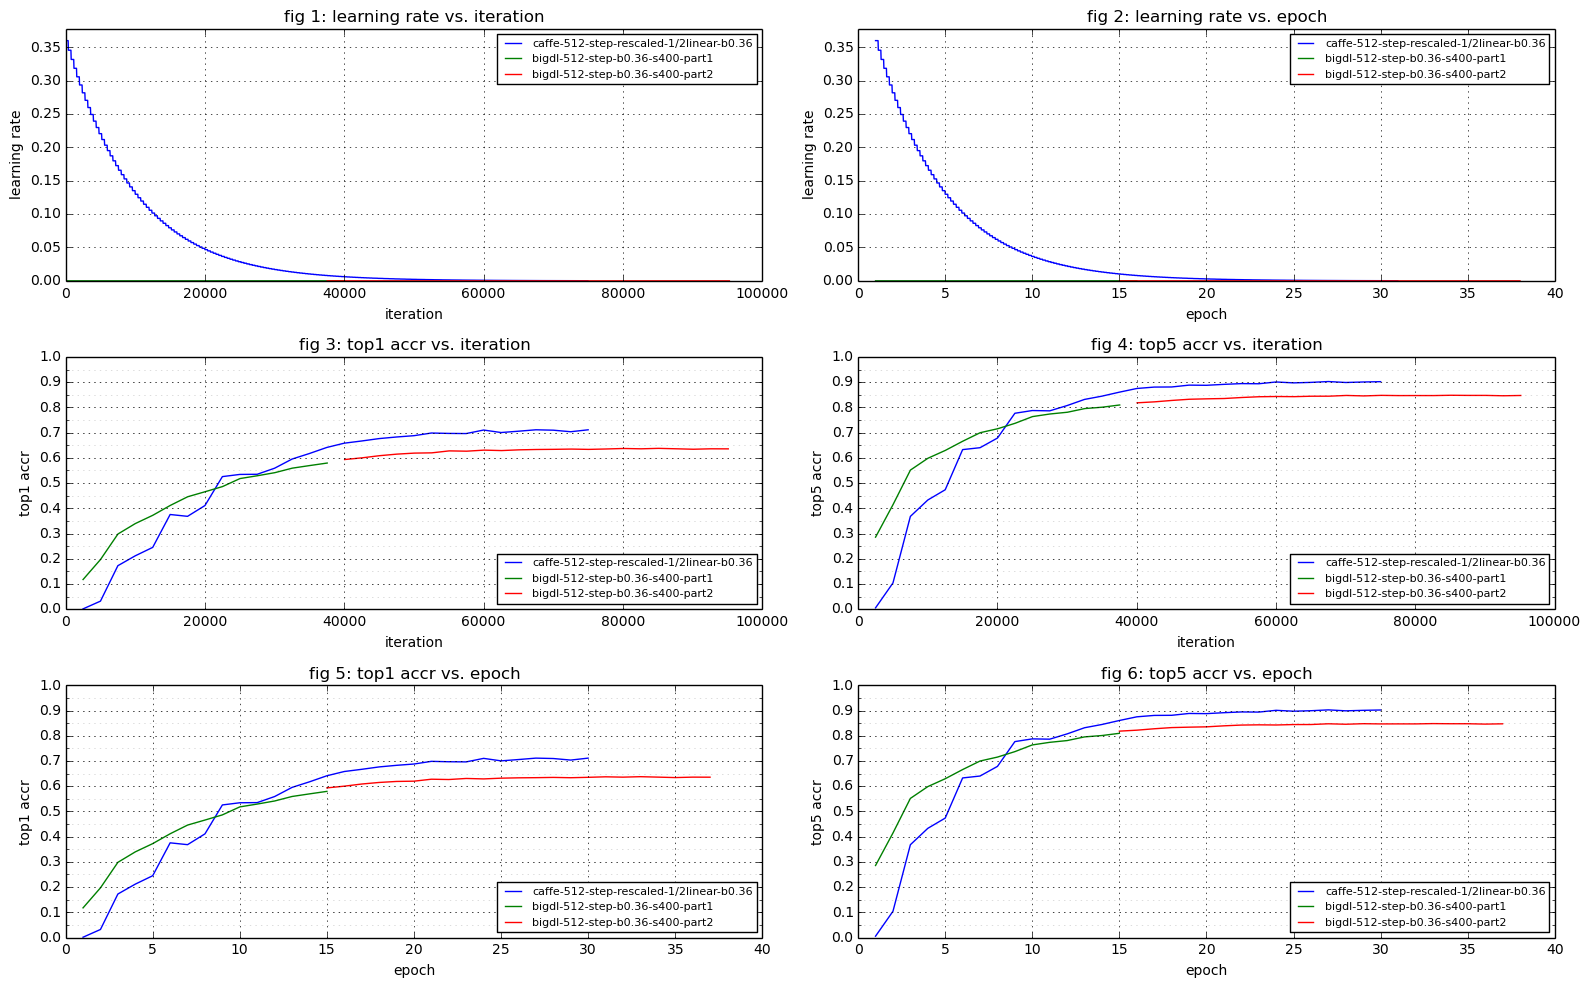

In [120]:
lineformats = plot_formats(len(result_tbls))
#plot the learning curve of one epoch
plt.figure(1,figsize=(16,10))
plt.title('Caffe Results')
lineformats = None
plot_lr_iter(321,result_tbls,lineformats)
plot_lr_epoch(322,result_tbls,lineformats)
plot_top1_iter(323,result_tbls,lineformats)
#plot_loss_iter(323,result_tbls,lineformats)
plot_top5_iter(324,result_tbls,lineformats)
plot_top1_epoch(325,result_tbls,lineformats)
#plot_loss_epoch(325,result_tbls,lineformats)
plot_top5_epoch(326,result_tbls,lineformats)

plt.tight_layout()

find_final_accuracy(tests,result_tbls)
